In [ ]:
# Installing required dependencies and loading configuration

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from collections import OrderedDict
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from efficientnet_pytorch import EfficientNet
from torchsampler import ImbalancedDatasetSampler
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from tqdm import tqdm
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv('../.env')

# ============================================================
# CONFIGURABLE PARAMETERS (loaded from .env or defaults)
# ============================================================
MODEL_NAME = os.getenv('MODEL_NAME', 'efficientnet-b0')
NUM_CLASSES = int(os.getenv('NUM_CLASSES', 7))
IMAGE_SIZE = int(os.getenv('IMAGE_SIZE', 256))

LEARNING_RATE = float(os.getenv('LEARNING_RATE', 0.001))
BATCH_SIZE = int(os.getenv('BATCH_SIZE', 32))
NUM_EPOCHS = int(os.getenv('NUM_EPOCHS', 22))
DROPOUT_RATE = float(os.getenv('DROPOUT_RATE', 0.4))

OPTIMIZER_TYPE = os.getenv('OPTIMIZER', 'adamw')
WEIGHT_DECAY = float(os.getenv('WEIGHT_DECAY', 0.01))

LR_STEP_SIZE = int(os.getenv('LR_STEP_SIZE', 7))
LR_GAMMA = float(os.getenv('LR_GAMMA', 0.1))

RANDOM_ROTATION = int(os.getenv('RANDOM_ROTATION', 10))
HORIZONTAL_FLIP_PROB = float(os.getenv('HORIZONTAL_FLIP_PROB', 0.5))

DATA_DIR = os.getenv('DATA_DIR', '../images/')
MODEL_SAVE_PATH = os.getenv('MODEL_SAVE_PATH', './efficientnet_b0_adamw_256x256.pt')
NUM_WORKERS = int(os.getenv('NUM_WORKERS', 10))

print("=" * 50)
print("TRAINING CONFIGURATION")
print("=" * 50)
print(f"Model: {MODEL_NAME}")
print(f"Image Size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Dropout: {DROPOUT_RATE}")
print(f"Optimizer: {OPTIMIZER_TYPE}")
print(f"LR Scheduler: step_size={LR_STEP_SIZE}, gamma={LR_GAMMA}")
print("=" * 50)

plt.ion()

In [ ]:
# Data augmentation and loading using configurable parameters

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomAffine(RANDOM_ROTATION),
        transforms.RandomHorizontalFlip(p=HORIZONTAL_FLIP_PROB),
        transforms.RandomRotation(RANDOM_ROTATION),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ]),
    'validation': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ['train', 'validation']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                              sampler=ImbalancedDatasetSampler(image_datasets[x]),
                                              num_workers=NUM_WORKERS)
              for x in ['train', 'validation']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes

print(f"Classes: {class_names}")
print(f"Number of classes: {len(class_names)}")
print(f"Training samples: {dataset_sizes['train']}")
print(f"Validation samples: {dataset_sizes['validation']}")

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

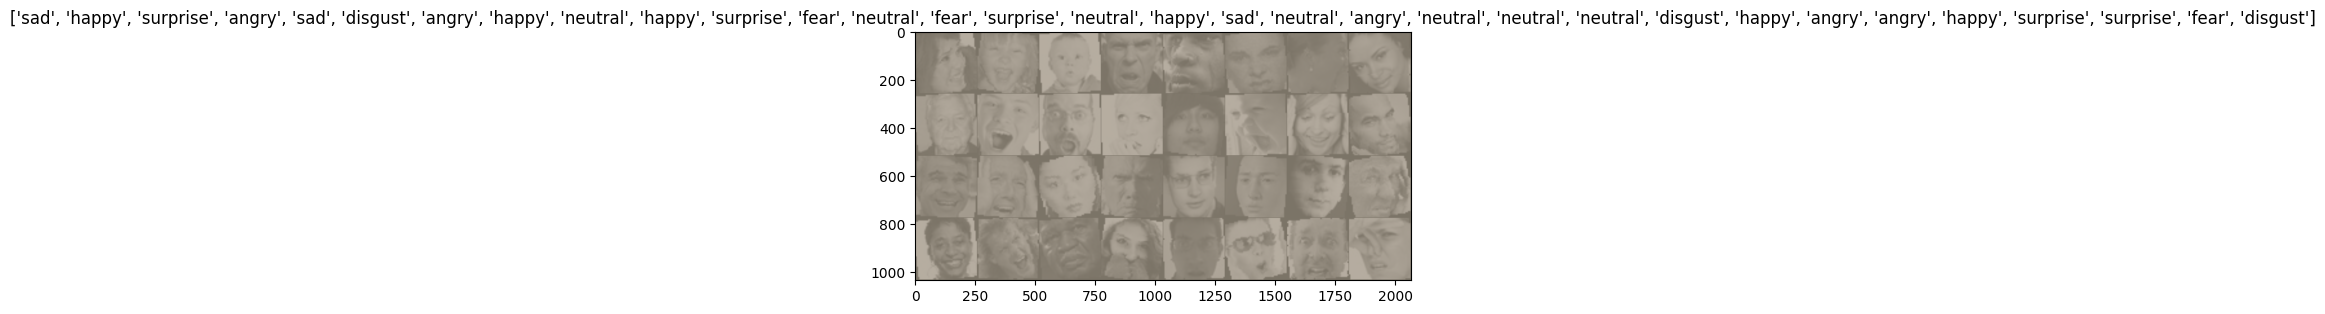

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            with tqdm(dataloaders[phase], unit="batch") as tepoch:
                for inputs, labels in tepoch:
                    tepoch.set_description(f"Epoch {epoch}")
                    inputs = inputs.to(device)
                    labels = labels.to(device)


                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # print(labels)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
# Model setup using configurable parameters

model_ft = EfficientNet.from_pretrained(MODEL_NAME)

# Unfreeze all layers for fine-tuning
for param in model_ft.parameters():
    param.requires_grad = True

# Custom classifier head
num_ftrs = model_ft._fc.in_features
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_ftrs, 512)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(DROPOUT_RATE)),
    ('fc2', nn.Linear(512, NUM_CLASSES))
]))
model_ft._fc = fc
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Optimizer selection
if OPTIMIZER_TYPE.lower() == 'adamw':
    optimizer_ft = optim.AdamW(model_ft.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
elif OPTIMIZER_TYPE.lower() == 'adam':
    optimizer_ft = optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)
elif OPTIMIZER_TYPE.lower() == 'sgd':
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, momentum=0.9)
else:
    optimizer_ft = optim.AdamW(model_ft.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=LR_STEP_SIZE, gamma=LR_GAMMA)

print(f"Model: {MODEL_NAME}")
print(f"Optimizer: {OPTIMIZER_TYPE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Dropout Rate: {DROPOUT_RATE}")

In [ ]:
# Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

In [ ]:
# Save the trained model
torch.save(model_ft, MODEL_SAVE_PATH)
print(f"Model saved to: {MODEL_SAVE_PATH}")